__File: srg_potentials_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     August 28, 2019__

This notebook creates several figures showing SRG-evolved NN potentials. Each function creates and saves a figure to the __Figures/SRG_potentials__ folder. Below is an outline of each function:
* potential_contours - Plots contours of an SRG-evolving potential in $\lambda$.
* potential_slices - Plots the diagonal or far off-diagonal matrix elements of an SRG-evolving potential in $\lambda$.
* potential_slices_high_cutoffs - Same as above function but specific to high cutoff non-local LO potentials from Wendt 2011 (kvnn = 900-902).

__Revision history:<br/>__
* September 6, 2019 - Generalized potential_diagonals and potential_off_diagonals functions to potential_slices function.
* September 13, 2019 - Changed potential_contours function to label either the potential, SRG generator, or channel.
* November 15, 2019 - Included high cutoff Wendt potentials (kvnn = 900-902). Use function potential_slices_high_cutoffs.

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# Scripts made by A.T.
from Figures import figures_functions as ff
import operators as op
from Potentials.vsrg_macos import load_save_potentials as lp

__Plotting functions__

In [2]:
def potential_contours(kvnn, channel, kmax, kmid, ntot, generator, lambda_array, label='potential'):
    """
    Plots SRG-evolved NN potential contours [fm] with respect to momentum [fm^-1]. This is an m x n figure where m 
    is the number of different SRG-evolved potentials and n is the number of lambda values in lambda_array.
    
    Parameters
    ----------
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *srg_potentials : tuple
        Specifications for SRG-evolved potentials in the format (kvnn, channel, kmax, kmid, ntot, generator) where 
        kvnn (int) is the number specifying the potential, channel (str) is the partial wave channel, kmax (float) 
        is the maximum value in the momentum mesh [fm^-1], kmid (float) is the mid-point value in the mesh [fm^-1], 
        ntot (int) is the number of points in the mesh, and generator (str) is the SRG-generator. For example, 
        (111, '1P1', 8.0, 2.0, 120, 'Wegner') corresponds to the Wegner decoupled RKE N4LO (450 MeV) potential in 
        the 1P1 channel.
    label : str, optional
        Option on what label to add to the figure: label either the NN potential, the partial wave channel, or the
        SRG generator. Default value is 'potential'; other values are 'generator' or 'channel'.

    Saves
    -----
    file_name = potential_contours_kvnns_ with an extension based off the given arguments. For example,
                potential_contours_kvnns_10_111_222_3S1_Wegner_potential_label.pdf.
    
    """
    
    
    # --- Set-up --- #
    
    # Load momentum for interpolation
    k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Limits of axes on contours (units are fm^-1)
    axes_max = 4.0
    
    # Specifications of x and y axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    # Limits of colorbar (units are fm) - depends on partial wave channel!
    if channel in ['1S0', '3S1']:
        mx = 1.0
        mn = -1.0
    elif channel in ['1P1']:
        mx = 0.4
        mn = -0.4
    else:
        mx = 1.0
        mn = -1.0
    
    # Labels
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    colorbar_label = '[fm]'
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    lambda_label_size = 17
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
    
    # Location of labels
    lambda_label_location = 'lower left'
    
    # Specifications for potential, generator, or channel label
    if label == 'potential':
        anchored_text_label = ff.kvnn_label_conversion(kvnn, full_label=False)
        anchored_text_label_size = 17
    elif label == 'generator':
        anchored_text_label = ff.generator_label_conversion(generator)
        anchored_text_label_size = 17
    else:
        anchored_text_label = ff.channel_label_conversion(channel)
        anchored_text_label_size = 22
    anchored_text_label_location = 'upper right'
        
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar
    
    # File name of figure
    # This reads 'potential_contours_kvnn_number_channel_generator_label'
    file_name = 'potential_contours_kvnn%d_%s_%s_%s_label' % (kvnn, channel, generator, label)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over lambda values keeping track of sub-plot number i
    i = 0
    for lamb in lambda_array:
        
        # Load evolved potential
        if generator == 'Block-diag':
            #V_evolved = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lambda_array[-1],
                                          #lambda_bd=lamb)
            V_evolved = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, np.array([1.0]),
                                          lambda_bd=lamb)
        else:
            V_evolved = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
        
        # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
        # interpolated)
        k_array_int, V_evolved_int = ff.interpolate_matrix(k_array, V_evolved, axes_max)
        
        # Add sub-plot to figure (for last sub-plot, must specify colorbar c)
        if i != ( len(lambda_array) - 1):
            axs[i].pcolormesh(k_array_int, k_array_int, V_evolved_int, cmap=color_style, vmin=mn, vmax=mx,
                              rasterized=True)
        else:
            c = axs[i].pcolormesh(k_array_int, k_array_int, V_evolved_int, cmap=color_style, vmin=mn, vmax=mx,
                                  rasterized=True)
            
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(axes_ticks)
        axs[i].xaxis.set_ticklabels(axes_ticks)
        
        # Specify axes limits
        axs[i].set_xlim( (0, axes_max) )
        axs[i].set_ylim( (0, axes_max) )
        
        # Position of x-axis label and tick marks
        axs[i].xaxis.set_label_position('top')
        axs[i].xaxis.tick_top()
        axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)
        
        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if i != ( len(lambda_array) - 1 ):
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
            
        # Set axes labels
        axs[i].set_xlabel(x_label, fontsize=axes_label_size)
        # Only specify y axis tick marks and set label for 1st sub-plot
        if i == 0:
            axs[i].yaxis.set_ticks(axes_ticks)
            axs[i].yaxis.set_ticklabels(axes_ticks)
            axs[i].set_ylabel(y_label, fontsize=axes_label_size)
            
        # Add potential, generator, or channel label as anchored text to last sub-plot
        if i == ( len(lambda_array) - 1):
            anchored_text = AnchoredText(anchored_text_label, prop=dict(size=anchored_text_label_size),
                                         loc=anchored_text_label_location)
            axs[i].add_artist(anchored_text)
            
        # Add lambda label as anchored text
        lambda_anchored_text = AnchoredText(lambda_label % lambda_array[i], prop=dict(size=lambda_label_size),
                                            loc=lambda_label_location)
        axs[i].add_artist(lambda_anchored_text)
            
        i += 1
    
    
    # --- Set figure specifications and save --- #
    
    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_potentials')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [3]:
def potential_slices(channel, lambda_array, *srg_potentials):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and far 
    off-diagonal matrix elements. This is a 2 x n figure where n is the number of lambda values in lambda_array.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *srg_potentials : tuple
        Specifications for SRG-evolved potentials in the format (kvnn, kmax, kmid, ntot, generator) where kvnn (int)
        is the number specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid
        (float) is the mid-point value in the mesh [fm^-1], ntot (int) is the number of points in the mesh, and 
        generator (str) is the SRG-generator. For example, (111, 8.0, 2.0, 120, 'Wegner') corresponds to the Wegner 
        decoupled RKE N4LO (450 MeV) potential.

    Saves
    -----
    file_name = potential_slices_kvnns_ with an extension based off the given arguments. For example,
                potential_slices_kvnns_10_111_222_3S1.pdf.
    
    """
    
    
    # Check that at least one potential was provided
    if not srg_potentials: 
        print('At least one SRG-evolved potential must be specified.')
        return None

    
    # --- Set-up --- #
    
    # Limits of x and y axes (dependent on channel and potential)
    xlim = [0.0, 3.0]
    if channel == '1S0':
        ylim = [-3.5, 2.0]
    elif channel == '3S1':
        ylim = [-4.5, 2.0]
    elif channel == '1P1':
        ylim = [-0.5, 0.8]
        
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    y_label_diag = 'V(k,k) [fm]'
    # Add channel label for diagonal element plot only
    channel_label = ff.channel_label_conversion(channel)
    # Set off-diagonal k = 0.5 fm^-1 for 1P1 channel
    if channel == '1P1':
        y_label_off_diag = 'V(k,0.5) [fm]'
    # Set off-diagonal k = 0 fm^-1 for other channels
    else:
        y_label_off_diag = 'V(k,0) [fm]'
    # Label for lambda and Lambda_BD
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    
    # Fontsize for labels and tick marks
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 17
    channel_label_size = 22
    lambda_label_size = 17
    axes_tick_size = 15
    
    # Location of labels
    legend_label_location = 'upper right'
    channel_label_location = 'lower right'
    lambda_label_location = 'upper left'
    
    # Size of figure
    row_number = 2
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Initialize file name of figure
    file_name = 'potential_slices_%s_kvnns' % channel # This reads 'potential_slices_channel_kvnns'
    # These lists will keep track of kvnn numbers and generators to be added to the file name
    kvnn_list = []

    # Current working directory
    cwd = getcwd()


    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over SRG-evolved potentials starting with the generator
    for generator in ['Wegner', 'Block-diag']:
        # Next potential specifications
        for potential in srg_potentials:
        
            # Set kvnn, kmax, kmid, ntot, and generator
            kvnn = potential[0]
            kmax = potential[1]
            kmid = potential[2]
            ntot = potential[3]
        
            # Keep track of kvnn numbers for file name at the end
            if kvnn not in kvnn_list:
                kvnn_list.append(kvnn)
            
            # Load momentum
            k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        
            # Curve labels and styles
            
            # Curve color depends on potential
            if kvnn in [10, 900]:
                curve_color = 'xkcd:black'
            elif kvnn in [105, 106, 107, 110, 111, 112, 901]:
                curve_color = 'xkcd:red'
            elif kvnn in [222, 224, 902]:
                curve_color = 'xkcd:blue'
                
            # Curve style depends on band- or block-diagonal generator
            # Put potential label on 1st sub-plot
            if generator == 'Block-diag':
                curve_style = 'dashed'
                potential_label = '' # No need to redundantly label the potentials
            else:
                curve_style = 'solid'
                potential_label = ff.kvnn_label_conversion(kvnn, full_label=False) # Legend label on 1st sub-plot
                
            # Put generator label on last sub-plot
            if kvnn == kvnn_list[0]:
                generator_label = ff.generator_label_conversion(generator)
            else:
                generator_label = '' # No need to redundantly label generators
        
            # Loop over lambda
            i = 0 # Sub-plot number
            for lamb in lambda_array:

                # Load evolved potential
                if generator == 'Block-diag':
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator,
                                                 lambda_array[-1], lambda_bd=lamb)
                else:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
            
                # Take a slice of the potential to plot
                # (indexing :ntot keeps the same dimension of k_array in the case of a coupled-channel potential)
                V_diag = np.diag( V_matrix[:ntot, :ntot] )
                # For 1P1 channel, select a slice where k does not equal zero
                if channel == '1P1':
                    k = 0.5
                    k_index = op.find_q_index(k, k_array) # k_array[k_index] ~ 1 fm^-1 (closest value to 1)
                    V_off_diag = V_matrix[:ntot, k_index]
                # Other channels, select k = 0
                else:
                    V_off_diag = V_matrix[:ntot, 0]
 
                # Add sub-plot to figure
                axs[0, i].plot(k_array, V_diag, color=curve_color, linestyle=curve_style)
                if i == 2: # 3rd sub-plot on bottom row - label generators
                    axs[1, i].plot(k_array, V_off_diag, color=curve_color, linestyle=curve_style, label=generator_label)
                elif i == ( len(lambda_array) - 1 ): # Last sub-plot on bottom row - label potentials
                    axs[1, i].plot(k_array, V_off_diag, color=curve_color, linestyle=curve_style, label=potential_label)
                else: # Middle sub-plots - no labels
                    axs[1, i].plot(k_array, V_off_diag, color=curve_color, linestyle=curve_style)
                
                i += 1
        
        
    # --- Set figure specifications and save --- #
    
    # Adjust y limits for Wendt high cutoff potentials
    if 900 in kvnn_list or 901 in kvnn_list or 902 in kvnn_list:
        ylim[0] += 0.5
        ylim[1] += 2.5
        
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    y_stepsize = 1       
    
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
    
    # Loop over sub-plots
    for k in range( len(lambda_array) ):
        
        # Specify axes limits
        axs[0, k].set_xlim(xlim)
        axs[0, k].set_ylim(ylim)
        axs[1, k].set_xlim(xlim)
        axs[1, k].set_ylim(ylim)
        
        # Make tick marks larger
        axs[0, k].xaxis.set_ticks(x_ticks)
        axs[0, k].yaxis.set_ticks(y_ticks)
        axs[0, k].tick_params(labelsize=axes_tick_size)
        axs[1, k].xaxis.set_ticks(x_ticks)
        axs[1, k].yaxis.set_ticks(y_ticks)
        axs[1, k].tick_params(labelsize=axes_tick_size)
        
        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if k != 3:
            xticks = axs[1, k].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
        # Prevent overlapping y-axis tick marks
        yticks = axs[0, 0].yaxis.get_major_ticks()
        yticks[0].set_visible(False)
            
        # Set axes labels
        axs[1, k].set_xlabel(x_label, fontsize=x_label_size)
        
        # Only specify y label and potential labels as legend for 1st and 5th sub-plots
        if k == 0:
            # Add y label
            axs[0, k].set_ylabel(y_label_diag, fontsize=y_label_size)
            axs[1, k].set_ylabel(y_label_off_diag, fontsize=y_label_size)

        # Add lambda's label as anchored text for top row sub-plots
        lambda_anchored_text = AnchoredText(lambda_label % lambda_array[k], prop=dict(size=lambda_label_size),
                                            loc=lambda_label_location, frameon=False)
        # Add lambda
        axs[0, k].add_artist(lambda_anchored_text)
            
        # Add channel label as anchored text to 3rd sub-plot
        if k == 2:
            channel_anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size),
                                                 loc=channel_label_location, frameon=False)
            axs[0, k].add_artist(channel_anchored_text)
         
        # Add generator and potential legends to 7th and 8th sub-plots
        if k == 2 or k == 3:
            axs[1, k].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    # Name of the file
    for kvnn in kvnn_list:
        file_name += '_%d' % kvnn
    # Add last value of lambda to file name
    file_name += '_lamb%.1f' % lambda_array[-1]
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_potentials')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [4]:
def potential_slices_high_cutoffs(lambda_array):
    """
    Plots SRG-evolved high-cutoff NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and far
    off-diagonal matrix elements. This is a 2 x n figure where n is the number of lambda values in lambda_array.
    Note, this function is analogous to the potentials_slices function.
    
    Parameters
    ----------
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Saves
    -----
    file_name = potential_slices_kvnns_900_901_902_3S1.pdf.
    
    """

    
    # --- Set-up --- #
    
    # Specifications of the potentials
    kvnn_list = [900, 901, 902]
    channel = '3S1'
    kmax = 30.0
    kmid = 4.0
    ntot = 120
    
    # Limits of x and y axes (dependent on channel and potential)
    xlim = [0.0, 3.0]
    ylim = [-4.0, 4.5]
        
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    if line == 'diag':
        y_label = 'V(k,k) [fm]'
        # Add channel label for diagonal element plot only
        channel_label = ff.channel_label_conversion(channel)
    elif line == 'off-diag':
        # Set off-diagonal k = 0.5 fm^-1 for 1P1 channel
        y_label = 'V(k,0) [fm]'
    # Label for lambda and Lambda_BD
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    
    # Fontsize for labels and tick marks
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 13
    channel_label_size = 22
    lambda_label_size = 17
    axes_tick_size = 18
    
    # Location of labels
    if line == 'diag':
        legend_label_location = 'lower left'
    else:
        legend_label_location = 'lower right'
    channel_label_location = 'lower right'
    lambda_label_location = 'upper left'
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Initialize file name of figure (this reads 'potential_line_channel_3S1_lamb')
    file_name = 'potential_%s_%s_kvnns_900_901_902_lamb%.1f' % (line, channel, lambda_array[-1])

    # Current working directory
    cwd = getcwd()


    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over SRG-evolved potentials starting with the generator
    for generator in ['Wegner', 'Block-diag']:
        # Next potential specifications
        for kvnn in kvnn_list:
            
            # Load momentum
            k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        
            # Curve labels and styles
            
            # Curve color depends on potential
            if kvnn == 900:
                curve_color = 'xkcd:black'
            elif kvnn == 901:
                curve_color = 'xkcd:red'
            elif kvnn == 902:
                curve_color = 'xkcd:blue'
                
            # Curve style depends on band- or block-diagonal generator
            # Put potential label on 1st sub-plot
            if generator == 'Block-diag':
                curve_style = 'dashed'
                potential_label = '' # No need to redundantly label the potentials
            else:
                curve_style = 'solid'
                potential_label = ff.kvnn_label_conversion(kvnn, full_label=False) # Legend label on 1st sub-plot
                
            # Put generator label on last sub-plot
            if kvnn == kvnn_list[0]:
                generator_label = ff.generator_label_conversion(generator)
            else:
                generator_label = '' # No need to redundantly label generators
        
            # Loop over lambda
            i = 0 # Sub-plot number
            for lamb in lambda_array:

                # Load evolved potential
                if generator == 'Block-diag':
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator,
                                                 lambda_array[-1], lambda_bd=lamb)
                else:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
            
                # Take a slice of the potential to plot
                # (indexing :ntot keeps the same dimension of k_array in the case of a coupled-channel potential)
                if line == 'diag':
                    V_vector = np.diag( V_matrix[:ntot, :ntot] )
                elif line == 'off-diag':
                    V_vector = V_matrix[:ntot, 0]
 
                # Add sub-plot to figure
                if i == 1: # 2nd sub-plot - label potential
                    axs[i].plot(k_array, V_vector, color=curve_color, linestyle=curve_style, label=potential_label)
                elif i == 2: # 3rd sub-plot - label generator
                    axs[i].plot(k_array, V_vector, color=curve_color, linestyle=curve_style, label=generator_label)
                else: # Middle sub-plots - no labels
                    axs[i].plot(k_array, V_vector, color=curve_color, linestyle=curve_style)
                
                i += 1
        
        
    # --- Set figure specifications and save --- #

    # Loop over sub-plots
    for j in range( len(lambda_array) ):
        
        # Specify axes limits
        axs[j].set_xlim(xlim)
        axs[j].set_ylim(ylim)

        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if j != ( len(lambda_array) - 1 ):
            xticks = axs[j].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
            
        # Set axes labels
        axs[j].set_xlabel(x_label, fontsize=x_label_size)
        
        # Only specify y label and potential labels as legend for 1st sub-plot
        if j == 0:
            # Add y label
            axs[j].set_ylabel(y_label, fontsize=y_label_size)

        # Specify potential labels as legend for 2nd sub-plot
        if j == 1:
            # Add legend for potentials
            axs[j].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
            
        # Specify generator labels as legend for 3rd sub-plot
        if j == 2:
            # Add legend for generators
            axs[j].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
            
        # Add channel label as anchored text to last sub-plot for diag plot only
        if line == 'diag' and j == ( len(lambda_array) - 1 ):
            channel_anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size),
                                                 loc=channel_label_location, frameon=False)
            axs[j].add_artist(channel_anchored_text)
            
        # Add lambda's label as anchored text
        lambda_anchored_text = AnchoredText(lambda_label % lambda_array[j], prop=dict(size=lambda_label_size),
                                            loc=lambda_label_location, frameon=False)
        # Add lambda
        axs[j].add_artist(lambda_anchored_text)
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_potentials')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

__Run functions in the cells below:__

In [5]:
# Fixed variables


ntot = 120

# Potentials formatted as (kvnn, kmax, kmid, ntot) tuples
# EM N3LO non-local potential at cutoff of 500 MeV
em_n3lo = (10, 30.0, 4.0, ntot)
# RKE N4LO semi-local potential at cutoff of 450 MeV
rke_n4lo = (111, 8.0, 2.0, ntot)
# Gezerlis et al N2LO local at cutoff 1.0 fm
gez_n2lo = (222, 10.0, 2.0, ntot)
# Wendt LO at cutoff 4 fm^-1
wendt_4 = (900, 30.0, 4.0, ntot)
# Wendt LO at cutoff 9 fm^-1
wendt_9 = (901, 30.0, 4.0, ntot)
# Wendt LO at cutoff 20 fm^-1
wendt_20 = (902, 30.0, 4.0, ntot)

# SRG lambda's array
lambda_array_contours = np.array( [6.0, 3.0, 2.0, 1.5] ) # For contours
lambda_array_slices = np.array( [6.0, 3.0, 1.5, 1.0] ) # For slices
lambda_array_high_cutoffs = np.array( [10.0, 2.8, 2.0, 1.2] ) # For high cutoff potentials

In [6]:
# Plot SRG-evolved potential contours


# AV18
# Wegner
#potential_contours(6, '3S1', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours)

# EM N3LO non-local potential at cutoff of 500 MeV
# Wegner
#potential_contours(10, '3S1', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(10, '3S1', 30.0, 4.0, ntot, 'Block-diag', lambda_array_contours)
# Wegner but 1S0 channel
#potential_contours(10, '1S0', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours)
# Wegner but 1P1 channel
#potential_contours(10, '1P1', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours)

# RKE N3LO semi-local potential at cutoff of 400 MeV
# Wegner labeling potential
#potential_contours(105, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(105, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours)

# RKE N3LO semi-local potential at cutoff of 450 MeV
# Wegner labeling potential
#potential_contours(106, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Wegner labeling generator
#potential_contours(106, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='generator')
# Wegner labeling channel
#potential_contours(106, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='channel')
# Block-diagonal labeling generator
#potential_contours(106, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours, label='generator')
# Wegner but 1S0 channel labeling channel
#potential_contours(106, '1S0', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='channel')
# Wegner but 1P1 channel labeling channel
#potential_contours(106, '1P1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='channel')
# Wegner but 1P1 channel labeling generator
#potential_contours(106, '1P1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='generator')
# Block-diagonal but 1P1 channel labeling generator
#potential_contours(106, '1P1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours, label='generator')

# RKE N3LO semi-local potential at cutoff of 500 MeV
# Wegner
#potential_contours(107, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(107, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours)

# RKE N4LO semi-local potential at cutoff of 450 MeV
# Wegner labeling potential
#potential_contours(111, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Wegner labeling generator
#potential_contours(111, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='generator')
# Wegner labeling channel
#potential_contours(111, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='channel')
# Block-diagonal labeling generator
#potential_contours(111, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours, label='generator')
# Wegner but 1S0 channel labeling channel
#potential_contours(111, '1S0', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='channel')
# Wegner but 1P1 channel labeling channel
#potential_contours(111, '1P1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='channel')
# Wegner but 1P1 channel labeling generator
#potential_contours(111, '1P1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='generator')
# Block-diagonal but 1P1 channel labeling generator
#potential_contours(111, '1P1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours, label='generator')

# RKE N4LO semi-local potential at cutoff of 500 MeV
# Wegner
#potential_contours(112, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(112, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours)

# Gezerlis et al N2LO local at cutoff 1.0 fm
# Wegner
#potential_contours(222, '3S1', 10.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(222, '3S1', 10.0, 2.0, ntot, 'Block-diag', lambda_array_contours)
# Wegner but 1S0 channel 
#potential_contours(222, '1S0', 10.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Wegner but 1P1 channel 
#potential_contours(222, '1P1', 10.0, 2.0, ntot, 'Wegner', lambda_array_contours)

# Gezerlis et al N2LO local at cutoff 1.2 fm
# Wegner
#potential_contours(224, '3S1', 10.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(224, '3S1', 10.0, 2.0, ntot, 'Block-diag', lambda_array_contours)

# Wendt LO non-local at cutoff 4 fm^-1
# Wegner
#potential_contours(900, '3S1', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(900, '3S1', 30.0, 4.0, ntot, 'Block-diag', lambda_array_contours)

# Wendt LO non-local at cutoff 9 fm^-1
# Wegner
#potential_contours(901, '3S1', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(901, '3S1', 30.0, 4.0, ntot, 'Block-diag', lambda_array_contours)

# Wendt LO non-local at cutoff 20 fm^-1
# Wegner
#potential_contours(902, '3S1', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(902, '3S1', 30.0, 4.0, ntot, 'Block-diag', lambda_array_contours)

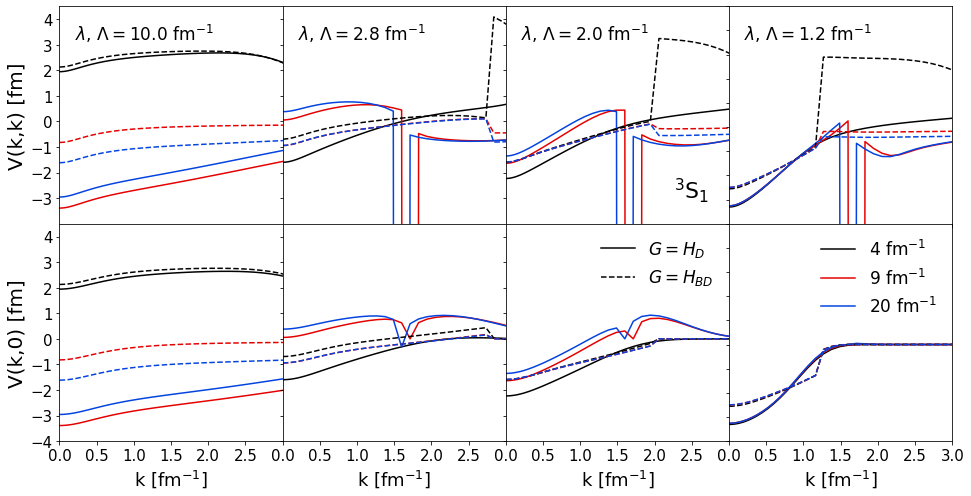

In [7]:
# Plot diagonal and off-diagonal matrix elements of SRG-evolved potentials


# Diagonal matrix elements for the three default SRG-evolved potentials with Wegner and block-diagonal generators
# 1S0
#potential_slices('diag', '1S0', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# 3S1
#potential_slices('diag', '3S1', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# 1P1
#potential_slices('diag', '1P1', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)

# Far off-diagonal matrix elements for the three default SRG-evolved potentials with Wegner and block-diagonal
# 1S0
#potential_slices('off-diag', '1S0', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# 3S1
#potential_slices('off-diag', '3S1', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# 1P1 
#potential_slices('off-diag', '1P1', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)

# Diagonal matrix elements for the three Wendt LO SRG-evolved potentials with Wegner and block-diagonal generators
#potential_slices_high_cutoffs('diag', lambda_array_high_cutoffs)

# Far off-diagonal matrix elements for the three Wendt LO SRG-evolved potentials with Wegner and block-diagonal
# generators
#potential_slices_high_cutoffs('off-diag', lambda_array_high_cutoffs)


# New combination of diagonal and far off-diagonal slices
# 3S1 high cutoffs
potential_slices('3S1', lambda_array_high_cutoffs, wendt_4, wendt_9, wendt_20)